Howework 4- Justin Talbot

In [1]:
import wget
wget.download('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv')

100% [..........................................................................] 1475504 / 1475504

'data (3).csv'

In [11]:
import pandas as pd
df = pd.read_csv('data.csv')


In [12]:
df = df[['Make',
'Model',
'Year',
'Engine HP',
'Engine Cylinders',
'Transmission Type',
'Vehicle Style',
'highway MPG',
'city mpg',
'MSRP']]

In [13]:
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [15]:
df.isnull().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64

In [16]:
df['engine_hp'] = df['engine_hp'].fillna(0).values

In [17]:
df['engine_cylinders'] = df['engine_cylinders'].fillna(0).values

In [22]:
mean = df.describe()['msrp']['mean']

In [25]:
 def above_average(msrp):
    return 1 if msrp >= mean else 0

In [26]:
df['above_average'] = df['msrp'].apply(above_average)

In [30]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

In [32]:
df.dtypes

make                  object
model                 object
year                   int64
engine_hp            float64
engine_cylinders     float64
transmission_type     object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
msrp                   int64
above_average          int64
dtype: object

In [33]:
categorical = ['make','model','transmission_type','vehicle_style']
numerical = ['year','engine_hp','engine_cylinders','highway_mpg','city_mpg']

Q1

In [47]:
from sklearn.metrics import roc_auc_score
roc_scores = []
for column in numerical:
    auc = roc_auc_score(y_train, df_train[column])
    if auc < .5:
        auc = roc_auc_score(y_train, -df_train[column])
    roc_scores.append((column, auc.round(3)))
roc_scores.sort(key=lambda x: x[1], reverse=True)
roc_scores

[('engine_hp', 0.917),
 ('engine_cylinders', 0.766),
 ('year', 0.688),
 ('city_mpg', 0.673),
 ('highway_mpg', 0.633)]

Q2

In [77]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

dv = DictVectorizer(sparse=False)
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [78]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

In [52]:
roc_auc_score(y_val, y_pred)

0.9790257223864177

Q3

In [79]:
import numpy as np
thresholds = np.linspace(0, 1, 101)

In [82]:
results = []
for t in thresholds:
    actual_pos = (y_val == 1)
    actual_neg = (y_val == 0)

    predict_pos = (y_pred >= t)
    predict_neg = (y_pred < t)

    tp = (predict_pos & actual_pos).sum()
    tn = (predict_neg & actual_neg).sum()

    fp = (predict_pos & actual_neg).sum()
    fn = (predict_neg & actual_pos).sum()
    
    results.append((t,tp,fp,fn,tn))

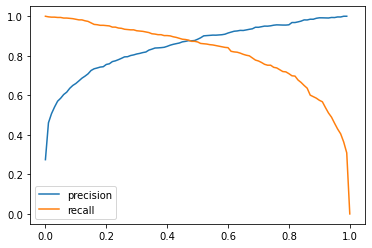

In [87]:
import matplotlib.pyplot as plt

columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_results = pd.DataFrame(results, columns=columns)

df_results['precision'] = df_results.tp / (df_results.tp + df_results.fp)
df_results['recall'] = df_results.tp / (df_results.tp + df_results.fn)

plt.plot(df_results.threshold, df_results['precision'], label='precision')
plt.plot(df_results.threshold, df_results['recall'], label='recall')
plt.legend()

In [95]:
for t in range(len(thresholds)):
    diff = df_results['precision'][t] - df_results['recall'][t]
    if -.01 < diff < .01:
        print(thresholds[t], diff.round(2))

0.46 -0.01
0.47000000000000003 -0.0
0.48 0.0
0.49 0.0


Q4

In [109]:

results = []
for t in thresholds:
    actual_pos = (y_val == 1)
    actual_neg = (y_val == 0)

    predict_pos = (y_pred >= t)
    predict_neg = (y_pred < t)

    tp = (predict_pos & actual_pos).sum()
    tn = (predict_neg & actual_neg).sum()

    fp = (predict_pos & actual_neg).sum()
    fn = (predict_neg & actual_pos).sum()
    
    results.append((t,tp,fp,fn,tn))
    
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_results = pd.DataFrame(results, columns=columns)

df_results['precision'] = df_results.tp / (df_results.tp + df_results.fp)
df_results['recall'] = df_results.tp / (df_results.tp + df_results.fn)

df_results['F1'] = 2 * ((df_results.precision * df_results.recall)/(df_results.precision + df_results.recall))

In [110]:
for t in range(len(thresholds)):
    f1 = df_results['F1'][t]
    print(thresholds[t], f1.round(2))

0.0 0.43
0.01 0.63
0.02 0.67
0.03 0.7
0.04 0.72
0.05 0.74
0.06 0.75
0.07 0.76
0.08 0.77
0.09 0.78
0.1 0.79
0.11 0.8
0.12 0.81
0.13 0.81
0.14 0.82
0.15 0.83
0.16 0.83
0.17 0.83
0.18 0.84
0.19 0.84
0.2 0.84
0.21 0.84
0.22 0.85
0.23 0.85
0.24 0.85
0.25 0.86
0.26 0.86
0.27 0.86
0.28 0.86
0.29 0.86
0.3 0.86
0.31 0.86
0.32 0.87
0.33 0.87
0.34 0.87
0.35000000000000003 0.87
0.36 0.87
0.37 0.87
0.38 0.87
0.39 0.87
0.4 0.87
0.41000000000000003 0.88
0.42 0.88
0.43 0.88
0.44 0.88
0.45 0.88
0.46 0.88
0.47000000000000003 0.88
0.48 0.87
0.49 0.88
0.5 0.88
0.51 0.88
0.52 0.88
0.53 0.88
0.54 0.88
0.55 0.88
0.56 0.88
0.5700000000000001 0.88
0.58 0.88
0.59 0.87
0.6 0.88
0.61 0.87
0.62 0.87
0.63 0.87
0.64 0.87
0.65 0.86
0.66 0.86
0.67 0.86
0.68 0.86
0.6900000000000001 0.85
0.7000000000000001 0.85
0.71 0.85
0.72 0.84
0.73 0.84
0.74 0.84
0.75 0.83
0.76 0.83
0.77 0.83
0.78 0.82
0.79 0.82
0.8 0.81
0.81 0.81
0.8200000000000001 0.81
0.8300000000000001 0.8
0.84 0.79
0.85 0.78
0.86 0.77
0.87 0.75
0.88 0.74
0.89 0

Q5

In [120]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.above_average.values
    y_val = df_val.above_average.values
    
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train,y_train)
    
    val_dicts = df_val[categorical + numerical].to_dict(orient='records')
    X_val = dv.transform(val_dicts)
    
    y_pred = model.predict_proba(X_val)[:, 1]

    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
print(np.mean(scores).round(2), np.std(scores).round(4))

C 0.98 0.0026


Q6

In [123]:
scores = []

for C in [0.01, 0.1, 0.5, 10]:
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dicts = df_train[categorical + numerical].to_dict(orient='records')
        X_train = dv.fit_transform(dicts)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train,y_train)

        val_dicts = df_val[categorical + numerical].to_dict(orient='records')
        X_val = dv.transform(val_dicts)

        y_pred = model.predict_proba(X_val)[:, 1]


        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print('C:',C,np.mean(scores).round(3), np.std(scores).round(4))

C: 0.01 0.952 0.0025
C: 0.1 0.962 0.0103
C: 0.5 0.968 0.012
C: 10 0.972 0.0127
